# Algorithms

In [1]:
def generate_convergent_diagonal(n):
    return np.diag(1 / np.arange(1, n + 1)**2)

def generate_random_gaussian_matrix(shape, mean=0, std=1):
    new_matrix = np.triu(np.random.normal(loc=mean, scale=std, size=shape))
    return new_matrix.T + new_matrix - np.diag(new_matrix.diagonal())

In [2]:
def rearrange_matrix_old(matrix, p, q):
    reshuffled_matrix = np.zeros((p * p, q * q))
    for i in range(p):
        for j in range(p):
            block = matrix[i * q:(i + 1) * q, j * q:(j + 1) * q]
            reshuffled_matrix[i * p + j] = block.flatten()
    return reshuffled_matrix


def inverse_rearrange_old(matrix, p, q):
    original_matrix = np.zeros((p * q, p * q))
    for i in range(p):
        for j in range(p):
            block = matrix[i * p + j].reshape(q, q)
            original_matrix[i * q:(i + 1) * q, j * q:(j + 1) * q] = block
    return original_matrix


# def thresholded_svd(matrix, lam):
#     u, s, vh = np.linalg.svd(matrix, full_matrices=False)
#     s_thresholded = np.maximum(s - lam / 2, 0)
#     return u @ np.diag(s_thresholded) @ vh

def rearrange_matrix_3d_old(matrix, p, q, r):
    reshuffled_matrix = np.zeros((p * p, q * q, r * r))
    for i in range(p):
        for j in range(p):
            for k in range(q):
                for l in range(q):
                    block = matrix[i * q * r + k * r: i * q * r + (k + 1) * r,
                                   j * q * r + l * r: j * q * r + (l + 1) * r]
                    reshuffled_matrix[i * p + j, k * q + l, :] = block.flatten()
    return reshuffled_matrix


def inverse_rearrange_3d_old(reshuffled_matrix, p, q, r):
    original_matrix = np.zeros((p * q * r, p * q * r))
    for i in range(p):
        for j in range(p):
            for k in range(q):
                for l in range(q):
                    block = reshuffled_matrix[i * p + j, k * q + l, :].reshape(r, r)
                    original_matrix[i * q * r + k * r: i * q * r + (k + 1) * r,
                                    j * q * r + l * r: j * q * r + (l + 1) * r] = block
    return original_matrix


def thresholded_svd(reshuffled_matrix, lam):
    reshaped_matrix = reshuffled_matrix.reshape(-1, reshuffled_matrix.shape[-1])
    u, s, vh = np.linalg.svd(reshaped_matrix, full_matrices=False)
    s_thresholded = np.maximum(s - lam / 2, 0)
    reshaped_matrix = u @ np.diag(s_thresholded) @ vh
    return reshaped_matrix.reshape(reshuffled_matrix.shape)

def rearrange_matrix_3d(matrix, p, q, r):
    reshaped = matrix.reshape(p, q, r, p, q, r)
    transposed = reshaped.transpose(0, 3, 1, 4, 2, 5)
    reshuffled_matrix = transposed.reshape(p * p, q * q, r * r)
    return reshuffled_matrix

def inverse_rearrange_3d(reshuffled_matrix, p, q, r):
    reshaped = reshuffled_matrix.reshape(p, p, q, q, r, r)
    transposed = reshaped.transpose(0, 2, 4, 1, 3, 5)
    original_matrix = transposed.reshape(p * q * r, p * q * r)
    return original_matrix

def rearrange_matrix(matrix, p, q):
    reshaped = matrix.reshape(p, q, p, q)
    transposed = reshaped.transpose(0, 2, 1, 3)
    reshuffled_matrix = transposed.reshape(p * p, q * q)
    return reshuffled_matrix

def inverse_rearrange(matrix, p, q):
    reshaped = matrix.reshape(p, p, q, q)
    transposed = reshaped.transpose(0, 2, 1, 3)
    return transposed.reshape(p * q, p * q)

In [3]:
import numpy as np

def tt_svd(X, max_rank=None, epsilon=1e-3):
    """
    Tensor Train Singular Value Decomposition (TT-SVD) with automatic rank determination.

    Parameters:
        X (ndarray): Input tensor of shape (n1, n2, ..., nd).
        max_rank (int): Maximum allowed TT-rank. If None, no maximum rank is enforced.
        epsilon (float): Tolerance for truncation.

    Returns:
        tt_cores (list): List of TT cores defining the TT decomposition.
    """
    d = X.ndim
    n = X.shape
    r = [1]

    tt_cores = []
    X_current = X

    for mu in range(d - 1):
        X_current = X_current.reshape(r[-1] * n[mu], -1)

        U, S, Vh = np.linalg.svd(X_current, full_matrices=False)

        sing_norm = np.cumsum(S**2) / np.sum(S**2)
        rank = np.searchsorted(sing_norm, 1 - epsilon) + 1

        if max_rank is not None:
            rank = min(rank, max_rank)

        U = U[:, :rank]
        S = S[:rank]
        Vh = Vh[:rank, :]

        core = U.reshape(r[-1], n[mu], rank)
        tt_cores.append(core)

        X_current = np.dot(np.diag(S), Vh)
        r.append(rank)

    tt_cores.append(X_current.reshape(r[-1], n[-1], 1))

    return tt_cores


def tt_hosvd(X, max_rank=None, epsilon=1e-3):
    factors = []
    for mode in [0, 2]:
        unfold = np.reshape(np.moveaxis(X, mode, 0), (X.shape[mode], -1))
        U, S, _ = np.linalg.svd(unfold, full_matrices=False)

        sing_norm = np.cumsum(S**2) / np.sum(S**2)
        rank = np.searchsorted(sing_norm, 1 - epsilon) + 1

        if max_rank is not None:
            rank = min(rank, max_rank)
        factors.append(U[:, :rank])
    core = np.einsum("ijk,ia,kc->ajc", X, *factors)
    return [factors[0][np.newaxis, ...] ] + [core] + [factors[1].T[..., np.newaxis]]

def hooi_tucker2(tt_cores, X, max_rank=None, epsilon=1e-3, max_iter=20):
    core = tt_cores[1]
    U1 = tt_cores[0].squeeze()
    U3 = tt_cores[2].squeeze().T

    for iteration in range(max_iter):
        unfolded = np.reshape(np.moveaxis(X, 0, 0), (X.shape[0], -1))
        U, S, _ = np.linalg.svd(unfolded @ np.kron(U3, np.eye(X.shape[1])), full_matrices=False)
        sing_norm = np.cumsum(S**2) / np.sum(S**2)
        rank = np.searchsorted(sing_norm, 1 - epsilon) + 1

        if max_rank is not None:
            rank = min(rank, max_rank)
        U1 = U[:, :rank]

        unfolded = np.reshape(np.moveaxis(X, 2, 0), (X.shape[2], -1))
        U, S, _ = np.linalg.svd(unfolded @ np.kron(np.eye(X.shape[1]), U1), full_matrices=False)
        sing_norm = np.cumsum(S**2) / np.sum(S**2)
        rank = np.searchsorted(sing_norm, 1 - epsilon) + 1

        if max_rank is not None:
            rank = min(rank, max_rank)
        U3 = U[:, :rank]

    core = np.einsum("ijk,ia,kc->ajc", X, U1, U3)
    return [U1[np.newaxis, ...]] + [core] + [U3.T[..., np.newaxis]]


def reconstruct_tt(tt_cores):
    """
    Reconstructs the original tensor from its TT cores.

    Parameters:
        tt_cores (list of ndarray): TT cores from the TT-SVD decomposition.

    Returns:
        ndarray: Reconstructed tensor.
    """
    X = tt_cores[0]
    for core in tt_cores[1:]:
        X = np.tensordot(X, core, axes=([-1], [0]))
    return X.squeeze()

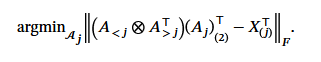

In [16]:
def right_orthonormalize_tt(tt_cores):
    cores = [core.copy() for core in tt_cores]
    d = len(cores)
    for i in reversed(range(1, d)):
        r_i, n_i, r_ip1 = cores[i].shape
        M = cores[i].reshape(r_i, n_i * r_ip1)
        Q, R = np.linalg.qr(M.T, mode='reduced')
        new_core = Q.T.reshape(r_i, n_i, r_ip1)
        cores[i] = new_core
        cores[i-1] = np.tensordot(cores[i-1], R.T, axes=([2], [0]))
    return cores


def tt_als(X, tt_cores_init, max_iter=50, tol=1e-6):
    """
    TT-ALS algorithm to optimize TT-cores.

    Parameters:
        X (ndarray): Original tensor.
        tt_cores_init (list): Initial TT cores from TT-SVD.
        max_iter (int): Number of ALS iterations.
        tol (float): Tolerance for stopping criterion (change in error).

    Returns:
        tt_cores (list): Optimized TT cores.
    """
    d = len(tt_cores_init)
    n = X.shape
    prev_error = np.inf
    #print([core.shape for core in tt_cores_init])

    for it in range(max_iter):
        tt_cores = right_orthonormalize_tt(tt_cores_init)
        for mu in range(d):
            L = np.array([[1.0]])
            for i in range(mu):
                L = np.tensordot(L, tt_cores[i], axes=([-1], [0]))
                L = L.reshape(-1, tt_cores[i].shape[2])
            R = np.array([[1.0]])
            for i in reversed(range(mu+1, d)):
                R = np.tensordot(tt_cores[i], R, axes=([2], [0]))
                R = R.reshape(tt_cores[i].shape[0], -1)
            # transpose_order = list(range(mu)) + list(range(mu, mu+1)) + list(range(mu+1, d))
            # X_mode = np.transpose(X, transpose_order)
            # left_dim = int(np.prod(n[:mu])) if mu > 0 else 1
            # right_dim = int(np.prod(n[mu+1:])) if mu < d-1 else 1
            # X_mode = X_mode.reshape(left_dim, n[mu], right_dim)
            # new_core = np.einsum('ia,ajb,bk->ijk', L.T, X_mode, R.T)
            transpose_order = list(range(mu)) + list(range(mu+1, d)) + [mu]
            B = np.transpose(X, transpose_order).reshape(-1, n[mu])
            A = np.kron(L, R.T)
            # print(A.shape)
            # print(B.shape)
            r_left = tt_cores[mu].shape[0]
            n_mu = tt_cores[mu].shape[1]
            r_right = tt_cores[mu].shape[2]
            new_core, _, _, _ = np.linalg.lstsq(A, B, rcond=None)
            # print(new_core.shape)
            # print()
            new_core = new_core.reshape(r_left, r_right, n_mu)
            new_core = np.transpose(new_core, (0, 2, 1))
            if mu < d - 1:
                M = new_core.reshape(r_left * n_mu, r_right)
                #assert (M == new_core).all()
                Q, Rfact = np.linalg.qr(M, mode='reduced')
                new_r = Q.shape[1]
                new_core = Q.reshape(r_left, n_mu, new_r)
                tt_cores[mu] = new_core
                tt_cores[mu+1] = np.tensordot(Rfact, tt_cores[mu+1], axes=([1], [0]))
            else:
                tt_cores[mu] = new_core

        X_recon = reconstruct_tt(tt_cores)
        error = np.linalg.norm(X - X_recon) / np.linalg.norm(X)
        if np.abs(prev_error - error) < tol:
            break
        # if it % 10 == 0:
        #     print(f"Iter {it}: error={error:e}")
        prev_error = error

    return tt_cores

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, svd

class TensorFactory:
    def __init__(self, tensor_size, alpha=0.1, construction='block-toeplitz'):

        self.tensor_size = tensor_size
        self.construction = construction
        self.alpha = alpha
        self.tensor = None
        self.noisy_tensor = None

    def create_tensor(self, std=1):
        if self.construction == 'block-toeplitz':
            self.tensor = self._generate_block_toeplitz()
        elif self.construction == 'exponential':
            self.tensor = self._generate_exponential_tensor()
        elif self.construction == 'sine':
            self.tensor = self._generate_sine_tensor()
        elif self.construction == 'kronecker':
            self.tensor = self._generate_kronecker_tensor()
        else:
            raise ValueError("Unsupported tensor construction type")
        noisy_tensor = np.random.normal(scale=std, size=self.tensor.shape)
        self.noisy_tensor = self.tensor + noisy_tensor
        return self.noisy_tensor

    def _generate_block_toeplitz(self):
        p, q = self.tensor_size[:2]
        num_blocks = 2 * q - 1
        blocks = [toeplitz(np.random.randn(p)) for _ in range(num_blocks)]
        block_toeplitz = np.zeros((p * q, p * q))

        for i in range(q):
            for j in range(q):
                block_idx = abs(i - j) % num_blocks
                block_toeplitz[i * p:(i + 1) * p, j * p:(j + 1) * p] = blocks[block_idx]

        return block_toeplitz

    def _generate_exponential_tensor(self):
        p, q = self.tensor_size[:2]
        X, Y = np.meshgrid(np.arange(p), np.arange(q), indexing='ij')
        tensor = np.exp(-alpha * (X + Y))
        return tensor.reshape(self.tensor_size)

    def _generate_sine_tensor(self):
        p, q = self.tensor_size[:2]
        X, Y = np.meshgrid(np.arange(p), np.arange(q), indexing='ij')
        tensor = np.sin(X - Y)
        return tensor.reshape(self.tensor_size)

    def _generate_kronecker_tensor(self):
        p, q, r, s = self.tensor_size
        A_list = [np.random.rand(p, p) for _ in range(s)]
        B_list = [np.random.rand(q, q) for _ in range(s)]
        C_list = [np.random.rand(r, r) for _ in range(s)]
        return sum(np.kron(np.kron(A, B), C) for A, B, C in zip(A_list, B_list, C_list))

    def sample_mean_error(self):
        return np.linalg.norm(self.noisy_tensor - self.tensor) / np.linalg.norm(self.tensor)

    def tt_svd_error(self, tt_rank=None, eps=1e-3, dim=3, als=False):
        if dim == 2:
            tt_decomposition = tt_svd(self.noisy_tensor, tt_rank, eps)
            if als:
                tt_decomposition = tt_als(self.noisy_tensor, tt_cores, max_iter=50, tol=1e-6)
            reconstructed_tensor = reconstruct_tt(tt_decomposition)
            error = np.linalg.norm(self.tensor - reconstructed_tensor) / np.linalg.norm(self.tensor)
        else:
            p, q, r, s = self.tensor_size
            noisy_tensor = rearrange_matrix_3d(self.noisy_tensor, p, q, r)
            tt_cores = tt_svd(noisy_tensor, epsilon=eps)
            if als:
                tt_cores = tt_als(noisy_tensor, tt_cores, max_iter=50, tol=1e-1)
            reconstructed_tensor = reconstruct_tt(tt_cores)
            reconstructed_cov_matrix = inverse_rearrange_3d(reconstructed_tensor, p, q, r)
            error = np.linalg.norm(self.tensor - reconstructed_cov_matrix) / np.linalg.norm(self.tensor)
        return error

    def svd_regularized_error(self, lam, dim=3):
        if dim == 2:
            estimated_reshuffled = thresholded_svd(self.noisy_tensor, lam)
            error = np.linalg.norm(self.tensor - estimated_reshuffled) / np.linalg.norm(self.tensor)
        else:
            reshuffled_matrix = rearrange_matrix_3d(self.noisy_tensor, self.tensor_size[0], self.tensor_size[1], self.tensor_size[2])
            estimated_reshuffled = thresholded_svd(reshuffled_matrix, lam)
            estimated_matrix = inverse_rearrange_3d(estimated_reshuffled, self.tensor_size[0], self.tensor_size[1], self.tensor_size[2])
            error = np.linalg.norm(self.tensor - estimated_matrix) / np.linalg.norm(self.tensor)
        return error

    def tt_hosvd_error(self, tt_rank=None, eps=1e-3, als=False):
        p, q, r, s = self.tensor_size
        noisy_tensor = rearrange_matrix_3d(self.noisy_tensor, p, q, r)
        tt_decomposition = tt_hosvd(noisy_tensor, tt_rank, eps)
        if als:
            tt_decomposition = hooi_tucker2(tt_decomposition, noisy_tensor, tt_rank, eps)
        reconstructed_tensor = reconstruct_tt(tt_decomposition)
        reconstructed_cov_matrix = inverse_rearrange_3d(reconstructed_tensor, p, q, r)
        error = np.linalg.norm(self.tensor - reconstructed_cov_matrix) / np.linalg.norm(self.tensor)
        return error


# Experiments

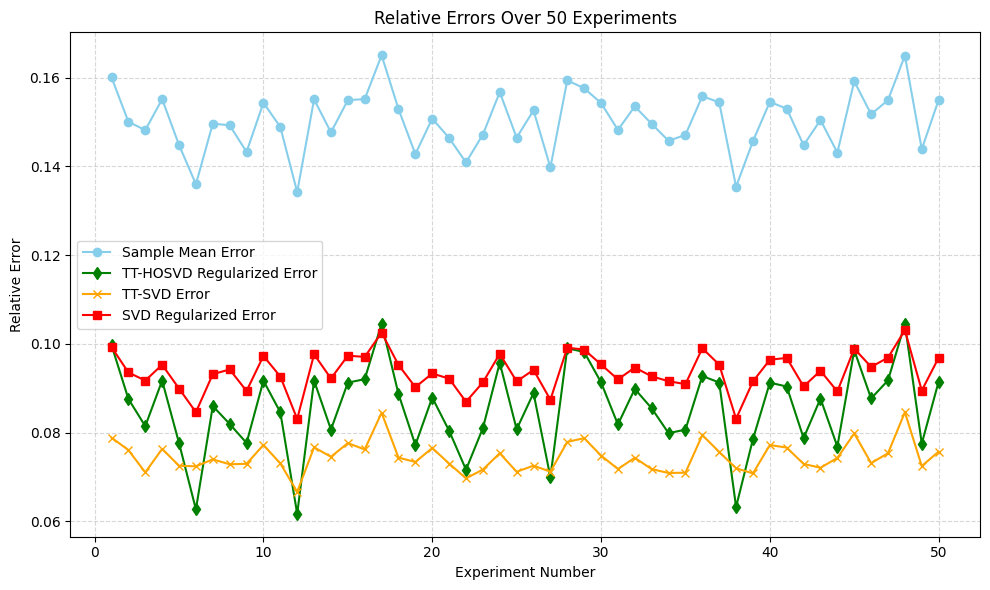

In [31]:
p = 7
q = 6
r = 5
s = 10
num_experiments = 50
lambda_reg = 10 # regularization parameter for Tsiligkaridis-Hero algo, basic 0.5
tensor_factory = TensorFactory(tensor_size=(p, q, r, s), construction='kronecker')
mean_errors = []
tt_svd_errors = []
svd_errors = []
hosvd_errors = []
tt_als_errors = []

for i in range(num_experiments):
    noisy_tensor = tensor_factory.create_tensor(std=0.2) #tunable noise parameter, depends on the quantity of samples
    mean_error = tensor_factory.sample_mean_error()
    tt_svd_error = tensor_factory.tt_svd_error(eps=10e-3) # penalisation parameter of noise reduction for TT-family algorithms
    #tt_als_error = tensor_factory.tt_svd_error(eps=5e-3, als=False) # parameter for als optimization
    svd_error = tensor_factory.svd_regularized_error(lambda_reg)
    hosvd_error = tensor_factory.tt_hosvd_error(eps=10e-3)
    mean_errors.append(mean_error)
    tt_svd_errors.append(tt_svd_error)
    #tt_als_errors.append(tt_als_error)
    svd_errors.append(svd_error)
    hosvd_errors.append(hosvd_error)

plt.figure(figsize=(10, 6))

plt.plot(range(1, num_experiments + 1), mean_errors, label="Sample Mean Error", color='skyblue', marker='o')
#plt.plot(range(1, num_experiments + 1), tt_als_errors, label="TT-ALS Error", color='skyblue', marker='o')
plt.plot(range(1, num_experiments + 1), hosvd_errors, label="TT-HOSVD Regularized Error", color='green', marker='d')
plt.plot(range(1, num_experiments + 1), tt_svd_errors, label="TT-SVD Error", color='orange', marker='x')
plt.plot(range(1, num_experiments + 1), svd_errors, label="SVD Regularized Error", color='red', marker='s')

plt.xlabel("Experiment Number")
plt.ylabel("Relative Error")
plt.title("Relative Errors Over 50 Experiments")
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

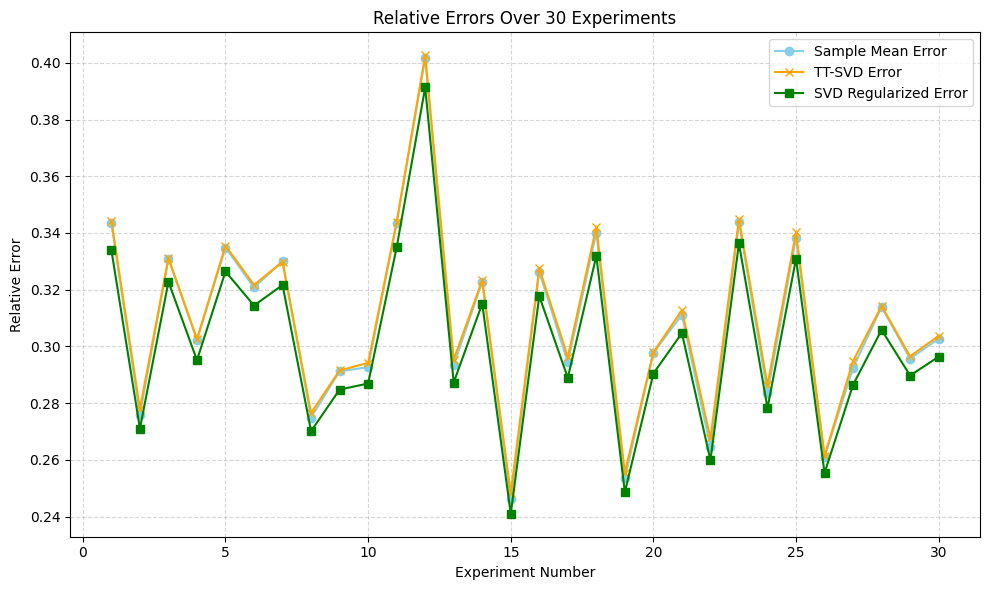

In [32]:
import matplotlib.pyplot as plt

p = 7
q = 10
num_experiments = 30
lambda_reg = 0.5
tensor_factory = TensorFactory(tensor_size=(p, q), construction='block-toeplitz')
mean_errors = []
tt_svd_errors = []
svd_errors = []

for i in range(num_experiments):
    noisy_tensor = tensor_factory.create_tensor(std=0.3)
    mean_error = tensor_factory.sample_mean_error()
    tt_svd_error = tensor_factory.tt_svd_error(eps=1e-3, dim=2)
    svd_error = tensor_factory.svd_regularized_error(lambda_reg, dim=2)
    mean_errors.append(mean_error)
    tt_svd_errors.append(tt_svd_error)
    svd_errors.append(svd_error)

plt.figure(figsize=(10, 6))

plt.plot(range(1, num_experiments + 1), mean_errors, label="Sample Mean Error", color='skyblue', marker='o')
plt.plot(range(1, num_experiments + 1), tt_svd_errors, label="TT-SVD Error", color='orange', marker='x')
plt.plot(range(1, num_experiments + 1), svd_errors, label="SVD Regularized Error", color='green', marker='s')

plt.xlabel("Experiment Number")
plt.ylabel("Relative Error")
plt.title("Relative Errors Over 30 Experiments")
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import kagglehub

path = kagglehub.dataset_download("fedesoriano/wind-speed-prediction-dataset")

print("Path to dataset files:", path)

In [ ]:
data = pd.read_csv("wind_dataset.csv")

0.03136825605779455


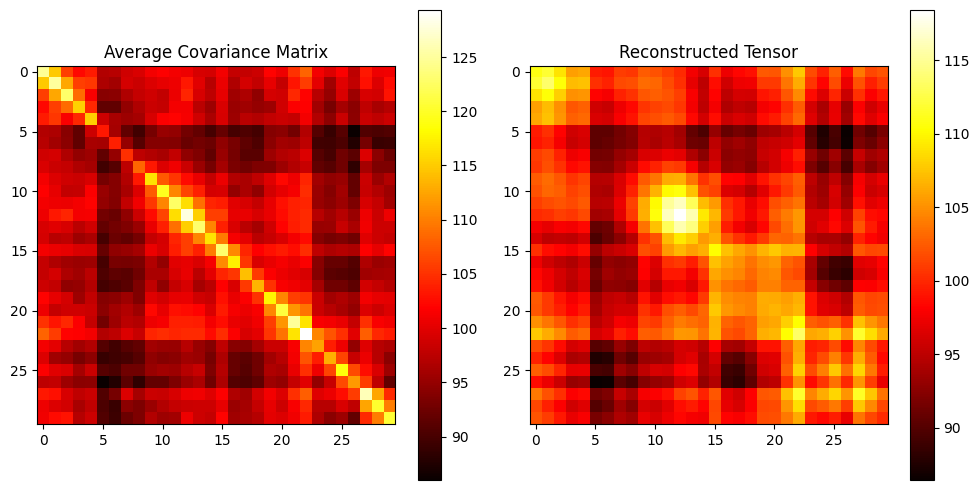

In [ ]:
numerical_columns = ["WIND"]
data = data[numerical_columns].dropna()

cov_matrices = []
window_size = 30
for start in range(0, len(data) - window_size + 1, window_size):
    window_data = data.iloc[start:start + window_size].values
    cov_matrix = np.outer(window_data, window_data)
    cov_matrices.append(cov_matrix)

avg_cov_matrix = np.mean(cov_matrices, axis=0)

tt_cores = tt_svd(avg_cov_matrix, max_rank=5, epsilon=1e-3)
reconstructed_tensor = reconstruct_tt(tt_cores)

error = np.linalg.norm(avg_cov_matrix - reconstructed_tensor) / np.linalg.norm(avg_cov_matrix)
print(error)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

im1 = ax1.imshow(avg_cov_matrix, cmap="hot", interpolation="nearest")
ax1.set_title("Average Covariance Matrix")
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(reconstructed_tensor, cmap="hot", interpolation="nearest")
ax2.set_title("Reconstructed Tensor")
fig.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

In [ ]:
from matplotlib import image, pyplot as plt

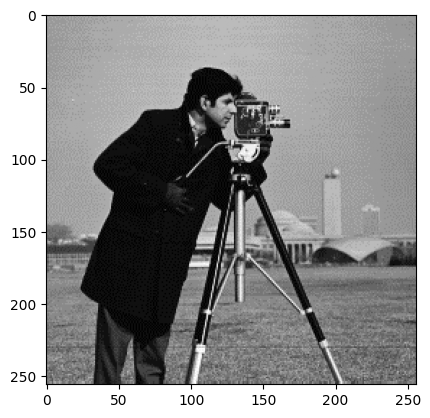

In [ ]:
im = image.imread("cameraman.png")[..., :3] # Fix strange size 513x513
plt.imshow(im[..., 2], cmap="gray")

0.9528756172952629


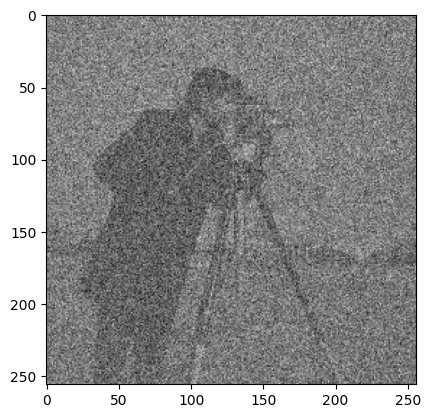

In [ ]:
pic = im[..., 0] + np.random.normal(scale=0.2, size=(256, 256))
error = np.linalg.norm(im[..., 0] - pic) / np.linalg.norm(im[..., 0])
print(error)
plt.imshow(pic, cmap="gray")

0.7600629581650516


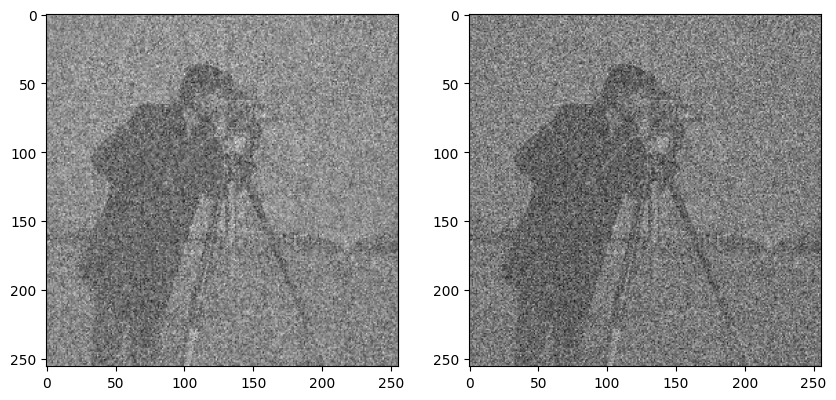

In [ ]:
noisy_tensor = rearrange_matrix_3d(pic, 8, 4, 8)
tt_cores = tt_svd(noisy_tensor)
tt_cores = tt_als(noisy_tensor, tt_cores, max_iter=50)
reconstructed_tensor = reconstruct_tt(tt_cores)
reconstructed_cov_matrix = inverse_rearrange_3d(reconstructed_tensor, 8, 4, 8)
error = np.linalg.norm(im[..., 0] - reconstructed_cov_matrix) / np.linalg.norm(im[..., 0])
print(error)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(reconstructed_cov_matrix, cmap="gray")
ax2.imshow(pic, cmap="gray")

# Experiments with TT-SVD

In [ ]:
from tensorflow.keras.datasets import mnist

(X_train, _), _ = mnist.load_data()
X = X_train[:100]
X_tensor = X.reshape(100, 28, 28)

tt_cores = tt_svd(X_tensor, 10, epsilon=1e-3)
X_reconstructed = reconstruct_tt(tt_cores)
print("MNIST Tensor Relative Error:", np.linalg.norm(X_tensor - X_reconstructed) / np.linalg.norm(X_tensor))


In [ ]:
k = 500
n = 1000
tensor_factory = TensorFactory(tensor_size=(n, n), construction='sine')

true_tensor = tensor_factory.create_tensor(std=1/np.sqrt(k))
mean_error = tensor_factory.sample_mean_error(noisy_tensor)
tt_svd_error = tensor_factory.tt_svd_error(tt_rank=2, eps=1e-3)

print("Sample Mean Error:", mean_error)
print("TT-SVD Error:", tt_svd_error)

Sample Mean Error: 0.06315533580717526
TT-SVD Error: 0.06302686916856616


In [ ]:
np.random.seed(42)
X = np.random.rand(4, 5, 6)
r_max = 5
epsilon = 1e-3

tt_cores = tt_svd(X, r_max, epsilon)

X_reconstructed = reconstruct_tt(tt_cores)

print("Reconstructed Tensor Shape:", X_reconstructed.shape)
print("Relative Error:", np.linalg.norm(X - X_reconstructed) / np.linalg.norm(X))

Reconstructed Tensor Shape: (4, 5, 6)
Relative Error: 0.14311194043295045


In [ ]:
X_low_rank = np.outer(np.random.rand(20), np.random.rand(30))
tt_cores = tt_svd(X_low_rank, 1, epsilon)
X_reconstructed = reconstruct_tt(tt_cores)

print("Low-Rank Relative Error:", np.linalg.norm(X_low_rank - X_reconstructed) / np.linalg.norm(X_low_rank))

Low-Rank Relative Error: 3.0613318655203046e-16


In [ ]:
X_sin = np.array([[np.sin(i - j) for j in range(100)] for i in range(100)])
tt_cores = tt_svd(X_sin, r_max, epsilon)
X_reconstructed = reconstruct_tt(tt_cores)

print("Sine Relative Error:", np.linalg.norm(X_sin - X_reconstructed) / np.linalg.norm(X_sin))


Sine Relative Error: 3.371364523341742e-16


In [ ]:
X_identity = np.eye(100)
tt_cores = tt_svd(X_identity, 100, epsilon)
X_reconstructed = reconstruct_tt(tt_cores)

print("Identity Matrix Relative Error:", np.linalg.norm(X_identity - X_reconstructed) / np.linalg.norm(X_identity))

Identity Matrix Relative Error: 0.0


In [ ]:
# X_large = np.random.rand(500, 500, 500)
# tt_cores = tt_svd(X_large, 20, epsilon=1e-3)
# X_reconstructed = reconstruct_tt(tt_cores)
# print("Large Tensor Relative Error:", np.linalg.norm(X_large - X_reconstructed) / np.linalg.norm(X_large))


In [ ]:
from tensorflow.keras.datasets import mnist

(X_train, _), _ = mnist.load_data()
X = X_train[:100]
X_tensor = X.reshape(100, 28, 28)

tt_cores = tt_svd(X_tensor, 10, epsilon=1e-3)
X_reconstructed = reconstruct_tt(tt_cores)
print("MNIST Tensor Relative Error:", np.linalg.norm(X_tensor - X_reconstructed) / np.linalg.norm(X_tensor))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MNIST Tensor Relative Error: 0.5022985417356688


In [ ]:
alpha = 0.1
shape = (20, 20)
X_tensor = np.zeros(shape)

for i in range(shape[0]):
    for j in range(shape[1]):
        X_tensor[i, j] = np.exp(-alpha * ((i - j)**2))

tt_cores = tt_svd(X_tensor, 10, epsilon=1e-3)

X_reconstructed = reconstruct_tt(tt_cores)


relative_error = np.linalg.norm(X_tensor - X_reconstructed) / np.linalg.norm(X_tensor)

print(f"Relative Error: {relative_error}")


Relative Error: 0.01619176589151577


In [ ]:
shape = (10, 10, 10)
X_tensor = np.zeros(shape)

for i in range(shape[0]):
    for j in range(shape[1]):
        for k in range(shape[2]):
            X_tensor[i, j, k] = 1 if i == j == k else 0

tt_cores = tt_svd(X_tensor, 10, epsilon=1e-3)

X_reconstructed = reconstruct_tt(tt_cores)

relative_error = np.linalg.norm(X_tensor - X_reconstructed) / np.linalg.norm(X_tensor)

print(f"Relative Error: {relative_error}")


Relative Error: 0.0


In [ ]:
np.random.seed(77)
n = 50

def experiment(n=100):
    diag_matrix = generate_convergent_diagonal(n)

    random_gaussian = generate_random_gaussian_matrix((n, n))
    Q1, _ = np.linalg.qr(random_gaussian)

    A = Q1 @ diag_matrix @ Q1.T

    random_gaussian_small = generate_random_gaussian_matrix((n, n), std=1/n)

    B = A + random_gaussian_small

    tt_cores = tt_svd(B, epsilon=1e-1)
    B_approx = reconstruct_tt(tt_cores).reshape(n, n)

    error_B = np.linalg.norm(A - B) / np.linalg.norm(A)
    error_B_approx = np.linalg.norm(A - B_approx) / np.linalg.norm(A)

    print("Relative Error between A and B:", error_B)
    print("Relative Error between A and TT-SVD(B):", error_B_approx)

    if error_B_approx < error_B:
        print("TT-SVD(B) provides a better approximation of A than B.")
    else:
        print("B provides a better approximation of A than TT-SVD(B).")
experiment(n)

Relative Error between A and B: 0.9952203023044793
Relative Error between A and TT-SVD(B): 0.9040014284965422
TT-SVD(B) provides a better approximation of A than B.


In [ ]:
experiment(500)

Relative Error between A and B: 0.9604433070938271
Relative Error between A and TT-SVD(B): 0.8562108828073645
TT-SVD(B) provides a better approximation of A than B.


In [ ]:
n = 120
k = 10

matrix1 = generate_random_gaussian_matrix((4, 4))
matrix2 = generate_random_gaussian_matrix((5, 5))
matrix3 = generate_random_gaussian_matrix((6, 6))

A = np.kron(matrix1, np.kron(matrix2, matrix3))

random_gaussian_small = generate_random_gaussian_matrix((n, n), std=1/np.sqrt(k))

B = A + random_gaussian_small

tt_cores = tt_svd(B, epsilon=1e-2)
B_approx = reconstruct_tt(tt_cores).reshape(n, n)

error_B = np.linalg.norm(A - B) / np.linalg.norm(A)
error_B_approx = np.linalg.norm(A - B_approx) / np.linalg.norm(A)

print("Relative Error between A and B:", error_B)
print("Relative Error between A and TT-SVD(B):", error_B_approx)

if error_B_approx < error_B:
    print("TT-SVD(B) provides a better approximation of A than B.")
else:
    print("B provides a better approximation of A than TT-SVD(B).")

Relative Error between A and B: 0.4232833204649586
Relative Error between A and TT-SVD(B): 0.41882442567528666
TT-SVD(B) provides a better approximation of A than B.


In [ ]:
n = 1000
k = 50
A = np.array([[np.sin(i - j) for j in range(n)] for i in range(n)])
random_gaussian_small = generate_random_gaussian_matrix((n, n), std=1/np.sqrt(k))

B = A + random_gaussian_small

tt_cores = tt_svd(B, epsilon=1e-3)
B_approx = reconstruct_tt(tt_cores).reshape(n, n)

error_B = np.linalg.norm(A - B) / np.linalg.norm(A)
error_B_approx = np.linalg.norm(A - B_approx) / np.linalg.norm(A)

print("Relative Error between A and B:", error_B)
print("Relative Error between A and TT-SVD(B):", error_B_approx)

if error_B_approx < error_B:
    print("TT-SVD(B) provides a better approximation of A than B.")
else:
    print("B provides a better approximation of A than TT-SVD(B).")

Relative Error between A and B: 0.1998853926540867
Relative Error between A and TT-SVD(B): 0.19728822695106332
TT-SVD(B) provides a better approximation of A than B.


In [ ]:
n = 1000
k = 50
alpha = 1 / (n * n)
shape = (n, n)
A = np.zeros(shape)

for i in range(shape[0]):
    for j in range(shape[1]):
        A[i, j] = np.exp(-alpha * ((i - j)**2))

random_gaussian_small = generate_random_gaussian_matrix((n, n), std=1/np.sqrt(k))

B = A + random_gaussian_small

tt_cores = tt_svd(B, epsilon=1e-3)
B_approx = reconstruct_tt(tt_cores).reshape(n, n)

error_B = np.linalg.norm(random_gaussian_small) / np.linalg.norm(A)
error_B_approx = np.linalg.norm(A - B_approx) / np.linalg.norm(A)

print("Relative Error between A and B:", error_B)
print("Relative Error between A and TT-SVD(B):", error_B_approx)

if error_B_approx < error_B:
    print("TT-SVD(B) provides a better approximation of A than B.")
else:
    print("B provides a better approximation of A than TT-SVD(B).")

Relative Error between A and B: 0.16204527989678705
Relative Error between A and TT-SVD(B): 0.15885894251262453
TT-SVD(B) provides a better approximation of A than B.


In [ ]:
import numpy as np
from scipy.linalg import toeplitz
n = 1000
k = 10

def generate_toeplitz_matrix(n):
    first_row = np.random.rand(n) * 10
    first_row[10:] = 0
    return toeplitz(first_row)

A = generate_toeplitz_matrix(n)
random_gaussian_small = generate_random_gaussian_matrix((n, n), std=1/np.sqrt(k))

B = A + random_gaussian_small

tt_cores = tt_svd(B, epsilon=1e-4)
B_approx = reconstruct_tt(tt_cores).reshape(n, n)

error_B = np.linalg.norm(A - B, ord="fro") / np.linalg.norm(A, ord="fro")
error_B_approx = np.linalg.norm(A - B_approx, ord="fro") / np.linalg.norm(A, ord="fro")

print("Relative Error between A and B:", error_B)
print("Relative Error between A and TT-SVD(B):", error_B_approx)

if error_B_approx < error_B:
    print("TT-SVD(B) provides a better approximation of A than B.")
else:
    print("B provides a better approximation of A than TT-SVD(B).")

Relative Error between A and B: 0.32267768988268314
Relative Error between A and TT-SVD(B): 0.32272235920212966
B provides a better approximation of A than TT-SVD(B).


# Part about Tsiligkaridis, Hero algo

In [ ]:
matrix_3x3 = np.random.randint(0, 5, size=(3, 3))
matrix_2x2 = np.random.randint(0, 5, size=(2, 2))

print("3x3 Matrix:\n", matrix_3x3)
print("\n2x2 Matrix:\n", matrix_2x2)

3x3 Matrix:
 [[3 2 2]
 [0 1 4]
 [0 4 2]]

2x2 Matrix:
 [[0 2]
 [2 2]]


In [ ]:
A = np.kron(matrix_3x3, matrix_2x2)
print(A)

[[0 6 0 4 0 4]
 [6 6 4 4 4 4]
 [0 0 0 2 0 8]
 [0 0 2 2 8 8]
 [0 0 0 8 0 4]
 [0 0 8 8 4 4]]


In [ ]:
import numpy as np

np.random.seed(42)

p, q = 3, 3
s = 2

A_list = [np.random.rand(p, p) for _ in range(s)]
B_list = [np.random.rand(q, q) for _ in range(s)]
cov_matrix = sum(np.kron(A, B) for A, B in zip(A_list, B_list))

noisy_cov_matrix = cov_matrix + generate_random_gaussian_matrix(cov_matrix.shape, std=0.1)

lam = 0.5
reshuffled_matrix = rearrange_matrix(noisy_cov_matrix, p, q)
estimated_reshuffled = thresholded_svd(reshuffled_matrix, lam)
estimated_matrix = inverse_rearrange(estimated_reshuffled, p, q)

# print("Original Covariance Matrix:\n", cov_matrix)
# print("Noisy Covariance Matrix:\n", noisy_cov_matrix)
# print("Estimated Covariance Matrix:\n", estimated_cov_matrix)

frobenius_error = np.linalg.norm(cov_matrix - estimated_matrix, ord="fro") / np.linalg.norm(cov_matrix, ord="fro")
print("Relative Frobenius Error:", frobenius_error)
mean_error = np.linalg.norm(cov_matrix - noisy_cov_matrix) / np.linalg.norm(cov_matrix)
print("Sample Mean Relative Error:", mean_error)


Relative Frobenius Error: 0.12258576800118309
Sample Mean Relative Error: 0.15792976144787088


In [ ]:
rearrange_matrix(A, 3, 2)

array([[0., 6., 6., 6.],
       [0., 4., 4., 4.],
       [0., 4., 4., 4.],
       [0., 0., 0., 0.],
       [0., 2., 2., 2.],
       [0., 8., 8., 8.],
       [0., 0., 0., 0.],
       [0., 8., 8., 8.],
       [0., 4., 4., 4.]])

In [ ]:
inverse_rearrange(rearrange_matrix(A, 3, 2), 3, 2)

array([[0., 6., 0., 4., 0., 4.],
       [6., 6., 4., 4., 4., 4.],
       [0., 0., 0., 2., 0., 8.],
       [0., 0., 2., 2., 8., 8.],
       [0., 0., 0., 8., 0., 4.],
       [0., 0., 8., 8., 4., 4.]])

In [ ]:
p, q, r = 2, 2, 2
s = 3

A_list = [np.random.rand(p, p) for _ in range(s)]
B_list = [np.random.rand(q, q) for _ in range(s)]
C_list = [np.random.rand(r, r) for _ in range(s)]
cov_matrix = sum(np.kron(np.kron(A, B), C) for A, B, C in zip(A_list, B_list, C_list))

noisy_cov_matrix = cov_matrix + generate_random_gaussian_matrix(cov_matrix.shape, std=0.1)

lam = 0.5
reshuffled_matrix = rearrange_matrix_3d(noisy_cov_matrix, p, q, r)
estimated_reshuffled = thresholded_svd(reshuffled_matrix, lam)
estimated_matrix = inverse_rearrange_3d(estimated_reshuffled, p, q, r)

# print("Original Covariance Matrix:\n", cov_matrix)
# print("Noisy Covariance Matrix:\n", noisy_cov_matrix)
# print("Estimated Covariance Matrix:\n", estimated_matrix)

frobenius_error = np.linalg.norm(cov_matrix - estimated_matrix, ord="fro") / np.linalg.norm(cov_matrix, ord="fro")
print("Relative Frobenius Error:", frobenius_error)
mean_error = np.linalg.norm(cov_matrix - noisy_cov_matrix) / np.linalg.norm(cov_matrix)
print("Sample Mean Relative Error:", mean_error)


Relative Frobenius Error: 0.17167112941546409
Sample Mean Relative Error: 0.21424649788668743


In [ ]:
matrix_3x3 = np.random.randint(0, 5, size=(2, 2))
matrix_2x2 = np.random.randint(0, 5, size=(2, 2))
matrix_4x4 = np.random.randint(1, 5, size=(1, 1))
print("3x3 Matrix:\n", matrix_3x3)
print("\n2x2 Matrix:\n", matrix_2x2)
print("\n4x4 Matrix:\n", matrix_4x4)
# need 4x4 equal to 2x2

3x3 Matrix:
 [[0 1]
 [4 4]]

2x2 Matrix:
 [[4 2]
 [3 0]]

4x4 Matrix:
 [[3]]


In [ ]:
A = np.kron(matrix_2x2, np.kron(matrix_2x2, matrix_3x3))
A

array([[ 0, 16,  0,  8,  0,  8,  0,  4],
       [64, 64, 32, 32, 32, 32, 16, 16],
       [ 0, 12,  0,  0,  0,  6,  0,  0],
       [48, 48,  0,  0, 24, 24,  0,  0],
       [ 0, 12,  0,  6,  0,  0,  0,  0],
       [48, 48, 24, 24,  0,  0,  0,  0],
       [ 0,  9,  0,  0,  0,  0,  0,  0],
       [36, 36,  0,  0,  0,  0,  0,  0]])

In [ ]:
rearrange_matrix_3d(A, 2, 2, 2)

array([[[4., 4., 4., 4.],
        [0., 0., 0., 0.],
        [6., 6., 6., 6.],
        [2., 2., 2., 2.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[6., 6., 6., 6.],
        [0., 0., 0., 0.],
        [9., 9., 9., 9.],
        [3., 3., 3., 3.]],

       [[2., 2., 2., 2.],
        [0., 0., 0., 0.],
        [3., 3., 3., 3.],
        [1., 1., 1., 1.]]])

In [ ]:
rearrange_matrix_3d(A, 2, 2, 1)

array([[[4.],
        [4.],
        [4.],
        [4.]],

       [[0.],
        [0.],
        [0.],
        [0.]],

       [[6.],
        [6.],
        [6.],
        [6.]],

       [[2.],
        [2.],
        [2.],
        [2.]]])

In [ ]:
assert(np.allclose(inverse_rearrange_3d(rearrange_matrix_3d(A, 2, 2, 2), 2, 2, 2), A))

In [ ]:
p, q, r = 4, 4, 4
s = 3
np.random.seed(77)

A_list = [np.random.rand(p, p) for _ in range(s)]
B_list = [np.random.rand(q, q) for _ in range(s)]
C_list = [np.random.rand(r, r) for _ in range(s)]
cov_matrix = sum(np.kron(np.kron(A, B), C) for A, B, C in zip(A_list, B_list, C_list))

In [ ]:
noisy_cov_matrix = cov_matrix + generate_random_gaussian_matrix(cov_matrix.shape, std=0.1)
noisy_tensor = rearrange_matrix_3d(noisy_cov_matrix, p, q, r)

tt_cores = tt_svd(noisy_tensor, epsilon=1e-1)
reconstructed_tensor = reconstruct_tt(tt_cores)
reconstructed_cov_matrix = inverse_rearrange_3d(reconstructed_tensor, p, q, r)
tt_svd_error = np.linalg.norm(cov_matrix - reconstructed_cov_matrix) / np.linalg.norm(cov_matrix)

lam = 0.5
reshuffled_matrix = rearrange_matrix_3d(noisy_cov_matrix, p, q, r)
estimated_reshuffled = thresholded_svd(reshuffled_matrix, lam)
estimated_matrix = inverse_rearrange_3d(estimated_reshuffled, p, q, r)
tsiligkaridis_error = np.linalg.norm(cov_matrix - estimated_matrix) / np.linalg.norm(cov_matrix)
mean_error = np.linalg.norm(cov_matrix - noisy_cov_matrix) / np.linalg.norm(cov_matrix)

tt_hosvd_cores = tt_hosvd(reshuffled_matrix, epsilon=1e-1)
X_reconstructed = reconstruct_tt(tt_hosvd_cores)
hosvd_estimated = inverse_rearrange_3d(X_reconstructed, p, q, r)
hosvd_error = np.linalg.norm(cov_matrix - hosvd_estimated) / np.linalg.norm(cov_matrix)

print("TT-HOSVD Relative Error:", hosvd_error)
print("TT-SVD Relative Error:", tt_svd_error)
print("Tsiligkaridis-Hero Relative Error:", tsiligkaridis_error)
print("Sample Mean Relative Error:", mean_error)

TT-HOSVD Relative Error: 0.16188911729666913
TT-SVD Relative Error: 0.22435505455332094
Tsiligkaridis-Hero Relative Error: 0.23393389874862436
Sample Mean Relative Error: 0.2695438350013815


In [ ]:
def generate_block_toeplitz(p, q):
    num_blocks = 2 * q - 1
    blocks = [toeplitz(np.random.randn(p)) for _ in range(num_blocks)]
    block_toeplitz = np.zeros((p * q, p * q))
    for i in range(q):
        for j in range(q):
            block_idx = abs(i - j) % num_blocks
            block_toeplitz[i * p:(i + 1) * p, j * p:(j + 1) * p] = blocks[block_idx]
    return block_toeplitz


block_size, blocks_per_row = 14, 10

cov_matrix = generate_block_toeplitz(block_size, blocks_per_row)

noisy_cov_matrix = cov_matrix + generate_random_gaussian_matrix(cov_matrix.shape, std=0.02)

tt_cores = tt_svd(noisy_cov_matrix, epsilon=1e-4)
reconstructed_tensor = reconstruct_tt(tt_cores)

tt_svd_error = np.linalg.norm(cov_matrix - reconstructed_tensor) / np.linalg.norm(cov_matrix)

print("TT-SVD Relative Error:", tt_svd_error)

estimated_reshuffled = thresholded_svd(noisy_cov_matrix, lam)
tsiligkaridis_hero_error = np.linalg.norm(noisy_cov_matrix - estimated_reshuffled) / np.linalg.norm(noisy_cov_matrix)
mean_error = np.linalg.norm(cov_matrix - noisy_cov_matrix) / np.linalg.norm(cov_matrix)

mean_error = np.linalg.norm(cov_matrix - noisy_cov_matrix) / np.linalg.norm(cov_matrix)
print("Relative error for Tsiligkaridis-Hero:", tsiligkaridis_hero_error)
print("Sample Mean Relative Error:", mean_error)
if tt_svd_error < mean_error:
    print("TT-SVD(B) provides a better approximation of A than B.")
else:
    print("B provides a better approximation of A than TT-SVD(B).")

TT-SVD Relative Error: 0.022388471968722488
Relative error for Tsiligkaridis-Hero: 0.02100920686740258
Sample Mean Relative Error: 0.020048573478381095
B provides a better approximation of A than TT-SVD(B).


In [ ]:
p = 17
q = 18
lambda_reg = 0.5

original_matrix = generate_block_toeplitz(p, q)
noisy_matrix = original_matrix + generate_random_gaussian_matrix(original_matrix.shape, std=0.2)

tt_decomposition = tt_svd(noisy_matrix, epsilon=1e-4)
reconstructed_tensor = reconstruct_tt(tt_decomposition)
tt_svd_error = np.linalg.norm(original_matrix - reconstructed_tensor) / np.linalg.norm(original_matrix)

estimated_reshuffled = thresholded_svd(noisy_matrix, lam)
tsiligkaridis_hero_error = np.linalg.norm(original_matrix - estimated_reshuffled) / np.linalg.norm(original_matrix)
mean_error = np.linalg.norm(original_matrix - noisy_matrix) / np.linalg.norm(original_matrix)

print("Relative error for TT-SVD:", tt_svd_error)
print("Relative error for Tsiligkaridis-Hero:", tsiligkaridis_hero_error)
print("Sample Mean Relative Error:", mean_error)

Relative error for TT-SVD: 0.17619356495755717
Relative error for Tsiligkaridis-Hero: 0.1743940156807511
Sample Mean Relative Error: 0.17593940978856745


# HOSVD

In [ ]:
import numpy as np

def hosvd(X, ranks):
    factors = []
    for mode in range(3):
        unfold = np.reshape(np.moveaxis(X, mode, 0), (X.shape[mode], -1))
        U, _, _ = np.linalg.svd(unfold, full_matrices=False)
        factors.append(U[:, :ranks[mode]])

    core = np.einsum("ijk,ia,jb,kc->abc", X, *factors)
    return core, factors

def reconstruct_tucker(core, factors):
    return np.einsum("ijk,ai,bj,ck->abc", core, *factors)


X = np.random.rand(20, 20, 20)
ranks = (10, 10, 10)

core, factors = hosvd(X, ranks)

X_reconstructed = reconstruct_tucker(core, factors)
rel_error = np.linalg.norm(X - X_reconstructed) / np.linalg.norm(X)
print("Relative reconstruction error:", rel_error)


Relative reconstruction error: 0.4333805504740718


In [ ]:
def hooi(X, core, factors, num_iters=10):
    for _ in range(num_iters):
        for mode in range(3):
            proj = X.copy()
            for i, factor in enumerate(factors):
                if i != mode:
                    proj = np.tensordot(proj, factor.T, axes=(0, 1)) if i == 0 else np.tensordot(proj, factor.T, axes=(1, 1))

            unfold_proj = np.reshape(np.moveaxis(proj, mode, 0), (X.shape[mode], -1))

            U, _, _ = np.linalg.svd(unfold_proj, full_matrices=False)
            factors[mode] = U[:, :core.shape[mode]]

        core = X.copy()
        for i, factor in enumerate(factors):
            core = np.tensordot(core, factor.T, axes=(0, 1)) if i == 0 else np.tensordot(core, factor.T, axes=(0, 1))

    return core, factors

In [ ]:
r_max = 5
epsilon = 1e-3

tt_cores = tt_svd(X, r_max, epsilon)

X_reconstructed = reconstruct_tt(tt_cores)
for item in tt_cores:
    print(item.shape)
print("Relative Error:", np.linalg.norm(X - X_reconstructed) / np.linalg.norm(X))

(1, 20, 5)
(5, 20, 5)
(5, 20, 1)
Relative Error: 0.4707892983214188


In [ ]:
!pip install line_profiler
from line_profiler import LineProfiler

%load_ext line_profiler

def experiment():
    p = 5
    q = 4
    r = 6
    s = 3
    num_experiments = 10
    lambda_reg = 0.5

    tensor_factory = TensorFactory(tensor_size=(p, q, r, s), construction='kronecker')

    mean_errors = []
    tt_svd_errors = []
    svd_errors = []
    hosvd_errors = []

    for i in range(num_experiments):
        noisy_tensor = tensor_factory.create_tensor(std=0.1)
        mean_error = tensor_factory.sample_mean_error()
        tt_svd_error = tensor_factory.tt_svd_error(eps=1e-2, als=True)
        svd_error = tensor_factory.svd_regularized_error(lambda_reg)
        hosvd_error = tensor_factory.tt_hosvd_error(eps=1e-2)

        mean_errors.append(mean_error)
        tt_svd_errors.append(tt_svd_error)
        svd_errors.append(svd_error)
        hosvd_errors.append(hosvd_error)

    plt.figure(figsize=(10, 6))

    plt.plot(range(1, num_experiments + 1), mean_errors, label="Sample Mean Error", color='skyblue', marker='o')
    plt.plot(range(1, num_experiments + 1), hosvd_errors, label="TT-HOSVD Regularized Error", color='green', marker='d')
    plt.plot(range(1, num_experiments + 1), tt_svd_errors, label="TT-SVD Error", color='orange', marker='x')
    plt.plot(range(1, num_experiments + 1), svd_errors, label="SVD Regularized Error", color='red', marker='s')

    plt.xlabel("Experiment Number")
    plt.ylabel("Relative Error")
    plt.title("Relative Errors Over 10 Experiments")
    plt.legend()
    plt.grid(linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

profiler = LineProfiler()

profiler.add_function(TensorFactory.create_tensor)
profiler.add_function(TensorFactory.sample_mean_error)
profiler.add_function(TensorFactory.tt_svd_error)
profiler.add_function(TensorFactory.svd_regularized_error)
profiler.add_function(TensorFactory.tt_hosvd_error)

profiler.run('experiment()')

profiler.print_stats()

# Algo improvements

In [ ]:
import numpy as np
from scipy.linalg import svd

def tt_riemannian_optimization(X_target, initial_cores, lr=0.01, max_iter=100, tol=1e-6):
    """
    Riemannian optimization for TT decomposition.

    Parameters:
        X_target (np.ndarray): Target tensor.
        initial_cores (list): Initial TT cores.
        lr (float): Learning rate.
        max_iter (int): Maximum iterations.
        tol (float): Convergence tolerance.

    Returns:
        optimized_cores (list): Optimized TT cores.
    """
    d = len(initial_cores)
    cores = [core.copy() for core in initial_cores]
    X_target_flat = X_target.flatten()

    for iter in range(max_iter):
        X_current = reconstruct_tt(cores)
        error = np.linalg.norm(X_target_flat - X_current.flatten())
        if error < tol:
            print(f"Converged at iteration {iter} with error {error:.2e}")
            break
        grad = 2 * (X_current - X_target)

        tangent_grad_cores = project_gradient_to_tangent_space(grad, cores)
        cores = retract(cores, tangent_grad_cores, lr)

    return cores

def project_gradient_to_tangent_space(grad, cores):
    """
    Project Euclidean gradient onto tangent space using TT interfaces.
    """
    projected_cores = []
    d = len(cores)
    left_interface = np.ones((1, 1))

    for k in range(d):
        r_prev, n_k, r_next = cores[k].shape

        right_dims = grad.shape[k+1:]
        grad_reshaped = grad.reshape(
            -1,
            n_k * int(np.prod(right_dims))
        )
        projected = left_interface.T @ grad_reshaped

        projected_reshaped = projected.reshape(r_prev, n_k, -1)[:, :, :r_next]
        projected_cores.append(projected_reshaped)

        left_interface = np.tensordot(left_interface, cores[k], axes=([1], [0]))
        left_interface = left_interface.reshape(-1, r_next)

    return projected_cores

def retract(cores, tangent_cores, lr):
    """
    Retraction via TT-ROUND with rank preservation.
    """
    new_cores = []
    for core, delta in zip(cores, tangent_cores):
        updated_core = core - lr * delta
        U, S, Vh = svd(
            updated_core.reshape(core.shape[0], -1),
            full_matrices=False
        )

        U = U[:, :core.shape[2]]
        S = S[:core.shape[2]]
        Vh = Vh[:core.shape[2], :]

        new_core = (U @ np.diag(S)) @ Vh
        new_core = new_core.reshape(core.shape[0], core.shape[1], core.shape[2])
        new_cores.append(new_core)

    return new_cores

In [ ]:
def test_riemannian():
    np.random.seed(0)
    tt_cores_exact = [
        np.random.rand(1, 2, 2),
        np.random.rand(2, 2, 2),
        np.random.rand(2, 2, 1)
    ]
    X_exact = reconstruct_tt(tt_cores_exact)

    tt_cores_noisy = [core + 0.1*np.random.randn(*core.shape) for core in tt_cores_exact]
    initial_error = np.linalg.norm(X_exact - reconstruct_tt(tt_cores_noisy))

    tt_opt = tt_riemannian_optimization(
        X_exact, tt_cores_noisy,
        lr=0.1, max_iter=100, tol=1e-6
    )
    final_error = np.linalg.norm(X_exact - reconstruct_tt(tt_opt))

    assert final_error < initial_error, "Rim opt did not enhance error"
    print(f"Test passed: Initial error{initial_error:.2e} -> Final error {final_error:.2e}")